# RNN Track Filter for tree search

In this notebook we will take the trained RNN hit predictor and apply it to track search on ACTS events.

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['OMP_NUM_THREADS'] = '4'
cuda = False

In [2]:
from __future__ import print_function

# Data libraries
import numpy as np
import pandas as pd

# Deep learning
import torch

# Visualization
import matplotlib.pyplot as plt

# Local imports
from data import process_files
from track_filter import (select_hits, select_signal_hits,
                          remove_duplicate_hits, coord_scale)
import torchutils
torchutils.set_cuda(cuda)

%matplotlib notebook

In [3]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

def calc_dphi(phi1, phi2):
    """TODO: update this for signed dph"""
    dphi = np.abs(phi1 - phi2)
    idx = dphi > np.pi
    dphi[idx] = 2*np.pi - dphi[idx]
    return dphi

def calc_dR(eta1, eta2, phi1, phi2):
    deta = np.abs(eta1 - eta2)
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(deta*deta + dphi*dphi)

def calc_phi_z_distance(phi1, phi2, z1, z2):
    dphi = calc_dphi(phi1, phi2)
    dz = np.abs(z1 - z2)
    return np.sqrt(dphi*dphi + dz*dz)

def calc_eta_phi_distance(r1, phi1, z1, r2, phi2, z2):
    # First, calculate the eta coordinates
    eta1 = calc_eta(r1, z1)
    eta2 = calc_eta(r2, z2)
    deta = np.abs(eta1 - eta2)
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(dphi*dphi + deta*deta)    

In [4]:
data_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'
model_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNFilter_20180203_2242/model'
#model_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNFilter-2/model'

## FIXME
Need to ensure an independent data set

In [5]:
n_files = 1

all_files = os.listdir(data_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
hits_files = [os.path.join(data_dir, f) for f in hits_files[:n_files]]

In [6]:
%%time

n_workers = 1
hits = process_files(hits_files, num_workers=n_workers)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
CPU times: user 35.2 ms, sys: 52 ms, total: 87.2 ms
Wall time: 1min


In [7]:
print('Hits data shape:', hits.shape)

Hits data shape: (520540, 7)


In [8]:
%%time

# Select hits
selected_hits = remove_duplicate_hits(select_hits(hits))
print('selected barrel hits:', selected_hits.shape)
signal_hits = select_signal_hits(selected_hits)
print('signal track hits:', signal_hits.shape)

selected barrel hits: (265715, 7)
signal track hits: (134990, 7)
CPU times: user 20.2 s, sys: 46.9 ms, total: 20.2 s
Wall time: 20.2 s


In [9]:
event_groups = selected_hits.groupby('evtid')
sample_keys = signal_hits[['evtid', 'barcode']].drop_duplicates().values

In [10]:
print('Available sample keys:', sample_keys.shape[0])

Available sample keys: 13499


In [11]:
# Load the pre-trained model
model = torch.load(model_file)
model.eval()
model

HitPredictor(
  (lstm): LSTM(3, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2)
)

In [12]:
def center_hits_phi(hits, phi0):
    dphi = hits.phi - phi0
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    hits.phi = dphi
    
def make_inputs(x, phi0=0):
    """
    Takes a dataframe of hits and extracts out the model input features.    
    Scales the coordinates by standard factors and prepends a batch dimension.
    """
    return torchutils.np_to_torch(
        (x[['phi', 'z', 'layer']].values / coord_scale)
        .astype(np.float32))[None, :]

In [13]:
n_det_layers = 10
seed_size = 3

n_test = 10240

In [20]:
%%time

# Selected hit entries for every sample
sel_indices = []
# True labels of all selected hit entries
sel_labels = []

# Loop over samples
for k in sample_keys[:n_test]:

    # Gather the data
    sample_hits = event_groups.get_group(k[0]).sort_values('layer')
    sample_labels = sample_hits.barcode == k[1]
    
    # Prepare the seed
    seed_hits = sample_hits[(sample_hits.layer < seed_size) &
                            (sample_hits.barcode == k[1])]
    sel_idx = seed_hits.index
    
    # Center hits in phi on the first layer seed hit
    phi0 = sample_hits.phi.loc[sel_idx[0]]
    center_hits_phi(sample_hits, phi0)
    
    for layer in range(seed_size, n_det_layers):

        # Calculate the prediction for next layer
        model_input = make_inputs(sample_hits.loc[sel_idx])
        model_pred = model(model_input)[0, -1]
        pred = torchutils.torch_to_np(model_pred) * coord_scale[:2]

        # Select all hits on the next layer
        layer_hits = sample_hits[sample_hits.layer == layer]

        # Calculate distance from prediction.
        distances = calc_eta_phi_distance(layer_hits.r, layer_hits.phi, layer_hits.z,
                                          layer_hits.r, pred[0], pred[1])

        # Lets test out some sampling methods on the nearby hits
        break

        # Select the closest
        next_idx = distances.argmin()
        sel_idx = sel_idx.append(pd.Int64Index([next_idx]))
    
    # Testing
    break

    sel_indices.append(sel_idx)
    sel_labels.append(sample_labels.loc[sel_idx])

CPU times: user 21.5 ms, sys: 13 µs, total: 21.5 ms
Wall time: 19.8 ms


#### Some development

Sampling from the closest hits in eta-phi distance

In [27]:
distances

58    2.299024
32    2.788040
21    3.411846
51    2.532603
66    2.381315
42    2.757534
3     0.171072
dtype: float32

In [29]:
distances.sort_values().index

Int64Index([3, 58, 66, 51, 42, 32, 21], dtype='int64')

In [30]:
1. / distances

58    0.434967
32    0.358675
21    0.293096
51    0.394851
66    0.419936
42    0.362643
3     5.845498
dtype: float32

In [31]:
invdists = 1. / distances

In [33]:
invdists / invdists.sum()

58    0.053636
32    0.044228
21    0.036142
51    0.048689
66    0.051782
42    0.044717
3     0.720806
dtype: float32

In [35]:
w = invdists / invdists.sum()

In [38]:
w

58    0.053636
32    0.044228
21    0.036142
51    0.048689
66    0.051782
42    0.044717
3     0.720806
dtype: float32

In [110]:
layer_hits.sample(n=1, weights=w)

,evtid,barcode,layer,r,phi,z,volume
3,0,9007611571601408,3,172.548355,0.023681,-158.657013,0


#### End development section

In [14]:
# Stack the results into full dataset tensors
sel_labels = np.stack(sel_labels)
sel_indices = np.stack(sel_indices)

CPU times: user 8min 42s, sys: 3.95 s, total: 8min 46s
Wall time: 8min 46s


In [15]:
print('Fraction of correctly selected hits:', sel_labels[:, seed_size:].mean())

Fraction of correctly selected hits: 0.7763671875


### Visualize some samples

<IPython.core.display.Javascript object>


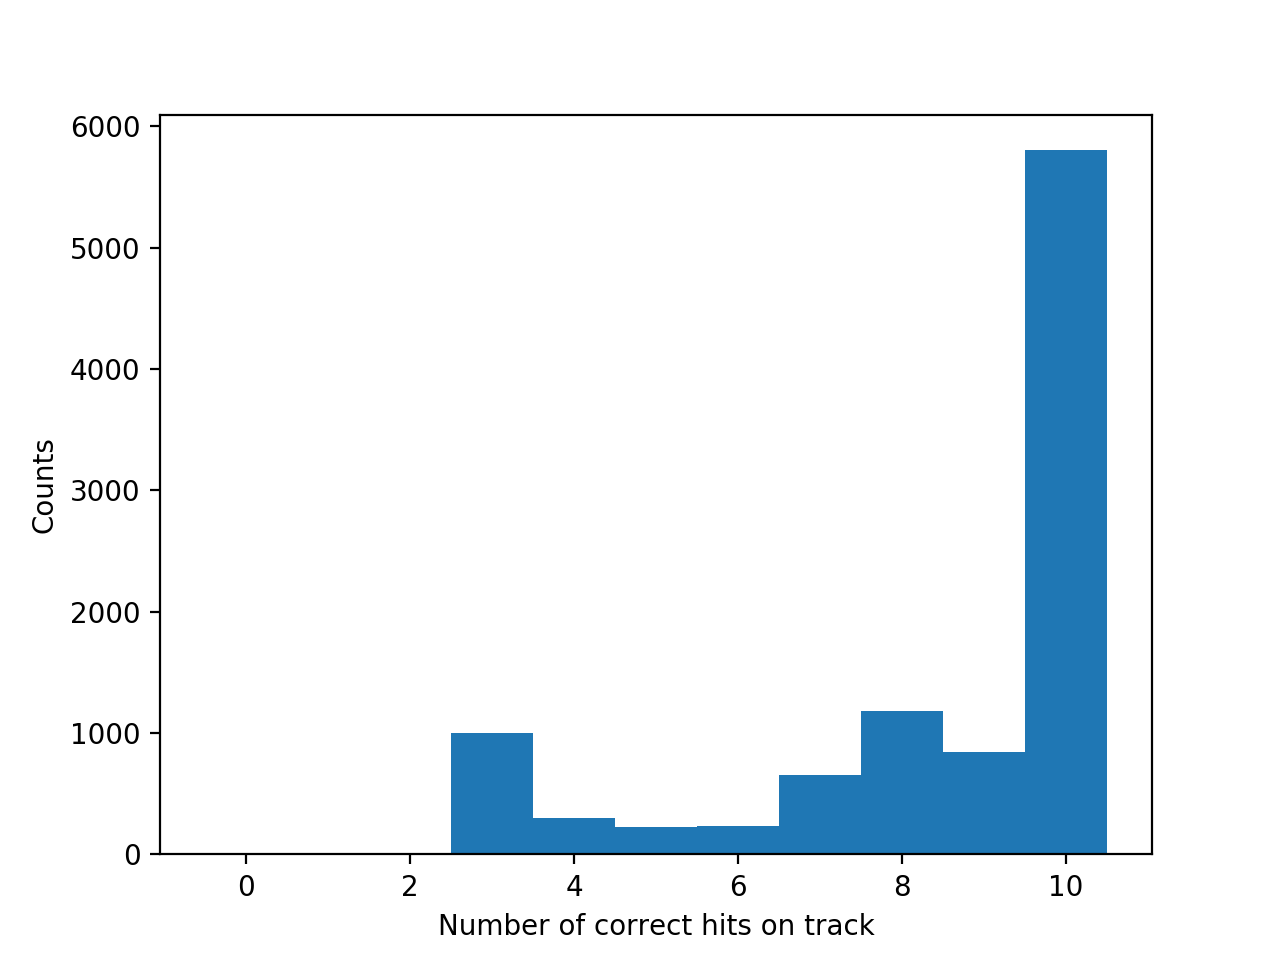

In [16]:
# Draw histogram of the number of correct hits in the predictions
correct_counts = sel_labels.sum(axis=1)

plt.figure()
plt.hist(correct_counts, range=(-0.5, 10.5), bins=11)
plt.xlabel('Number of correct hits on track')
plt.ylabel('Counts');

In [17]:
draw_samples = np.random.randint(n_test, size=5)
#draw_samples = [25, 48, 42, 64, 331, 228]

<IPython.core.display.Javascript object>


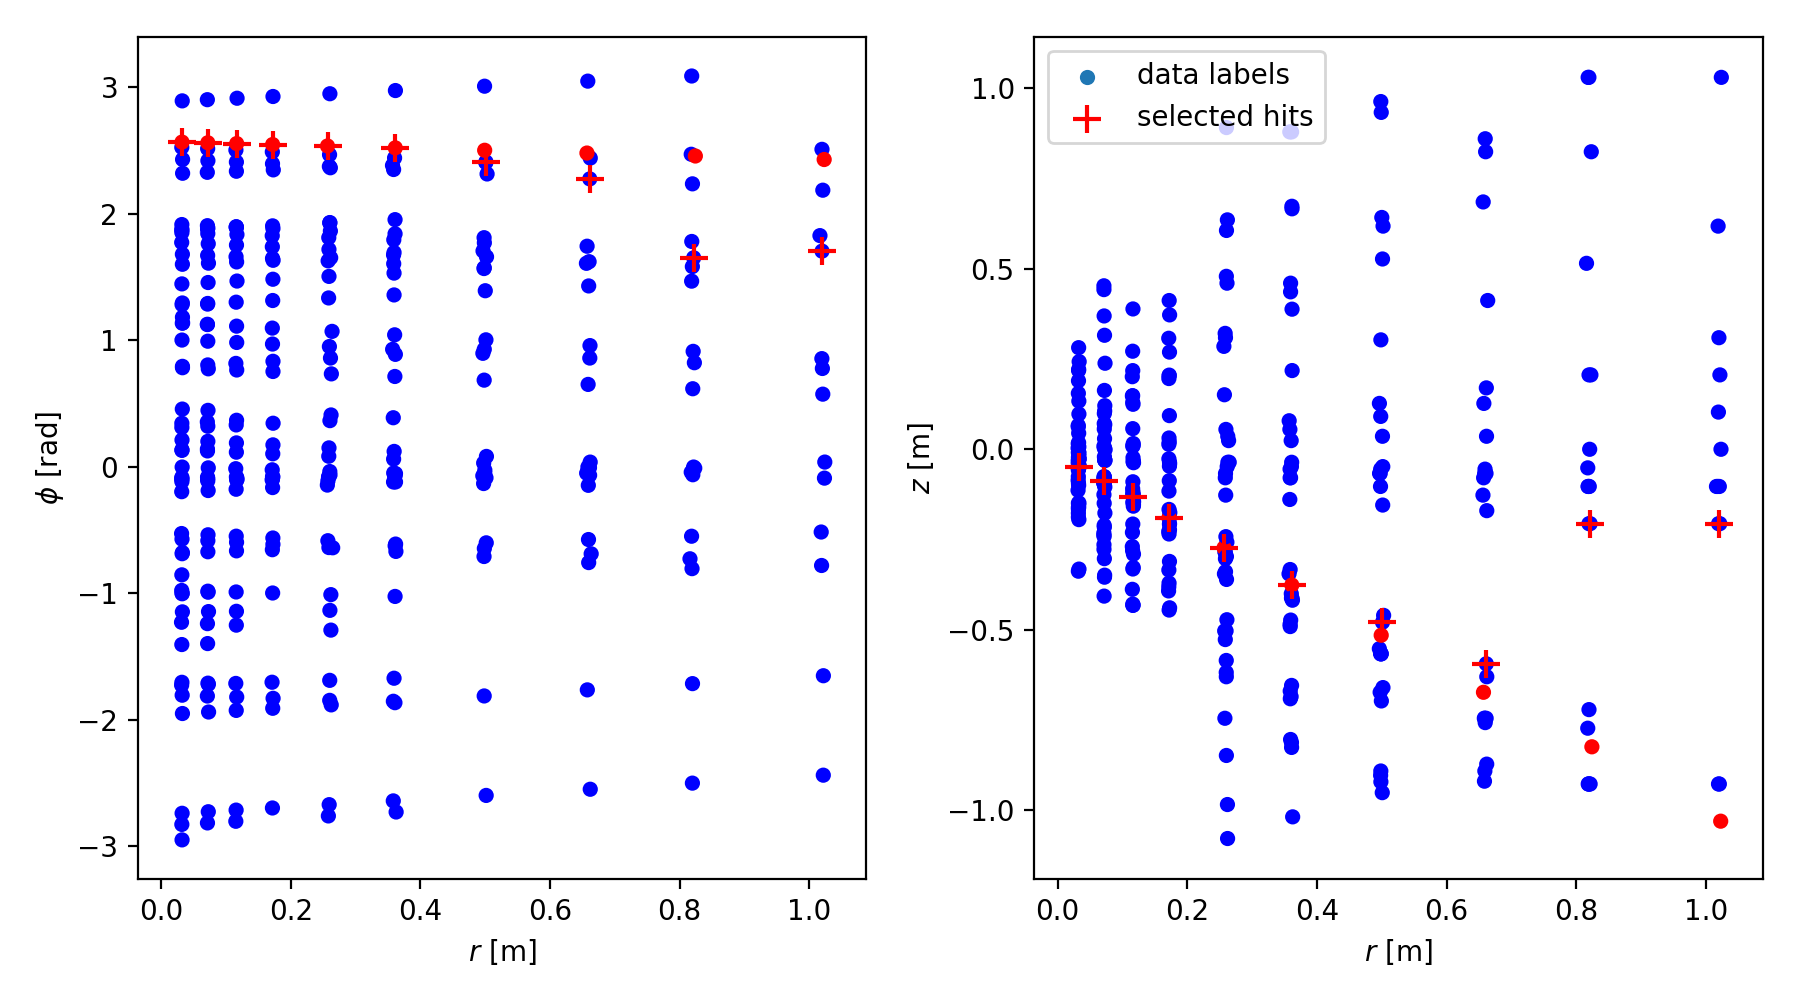

<IPython.core.display.Javascript object>


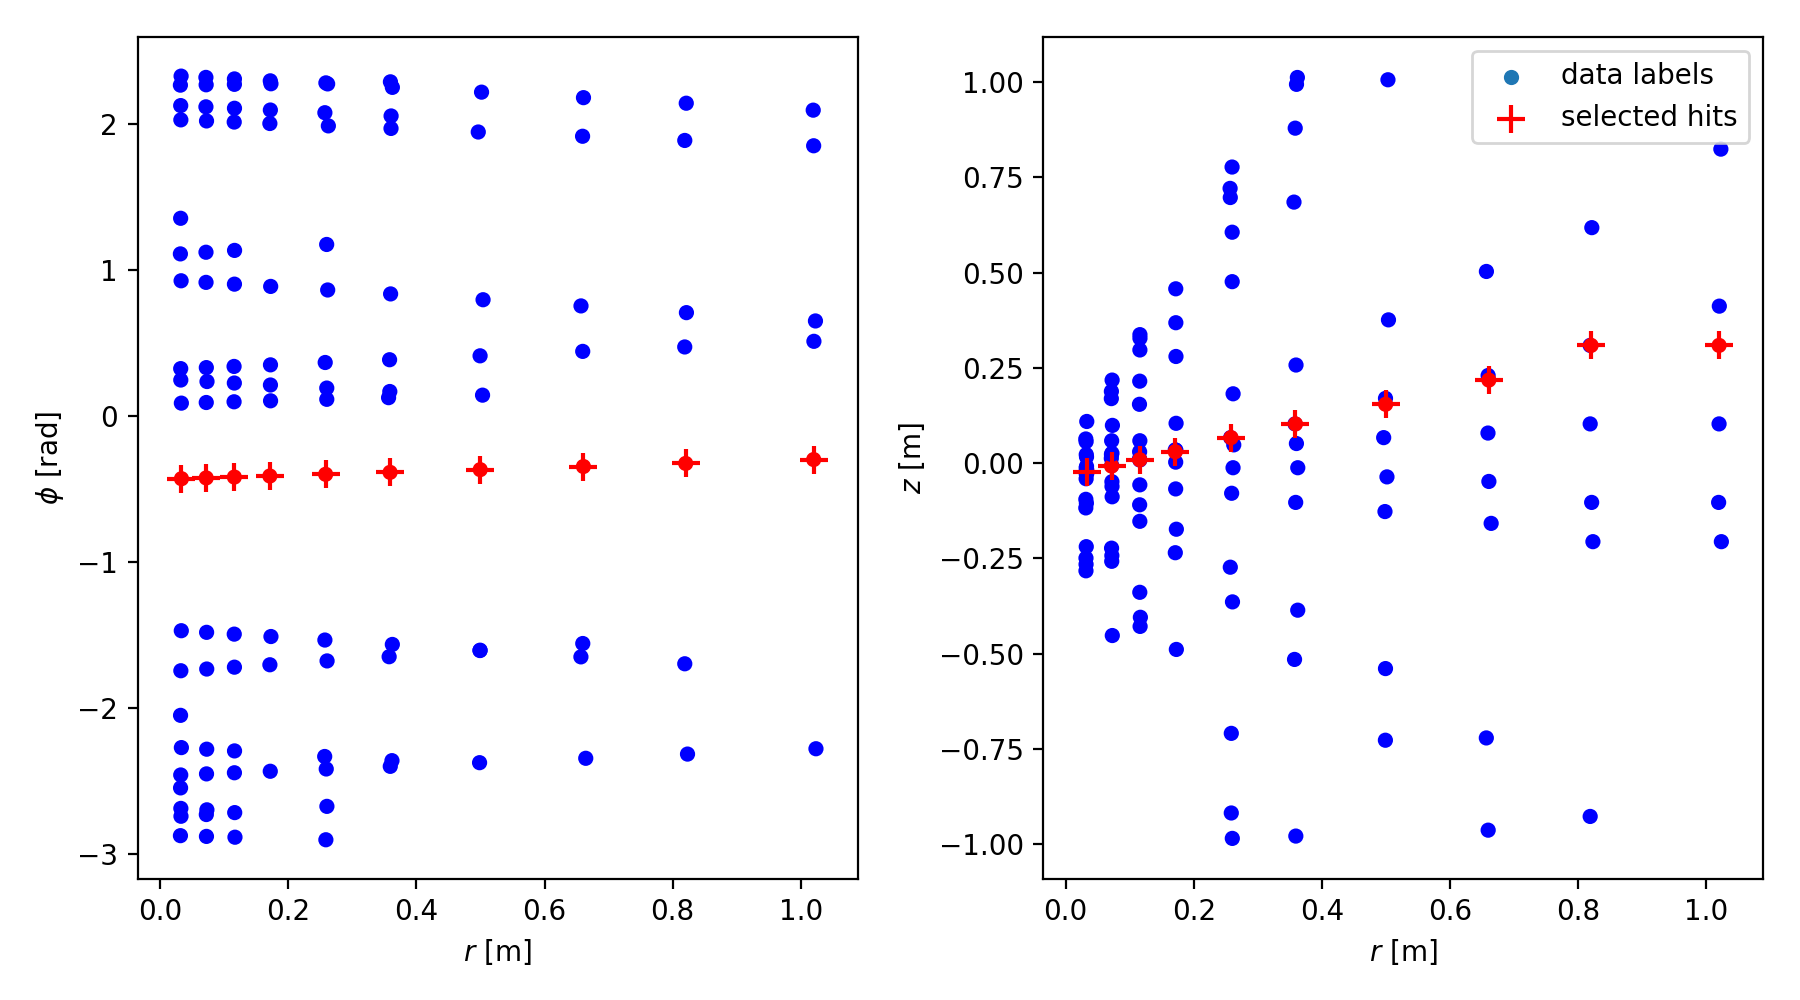

<IPython.core.display.Javascript object>


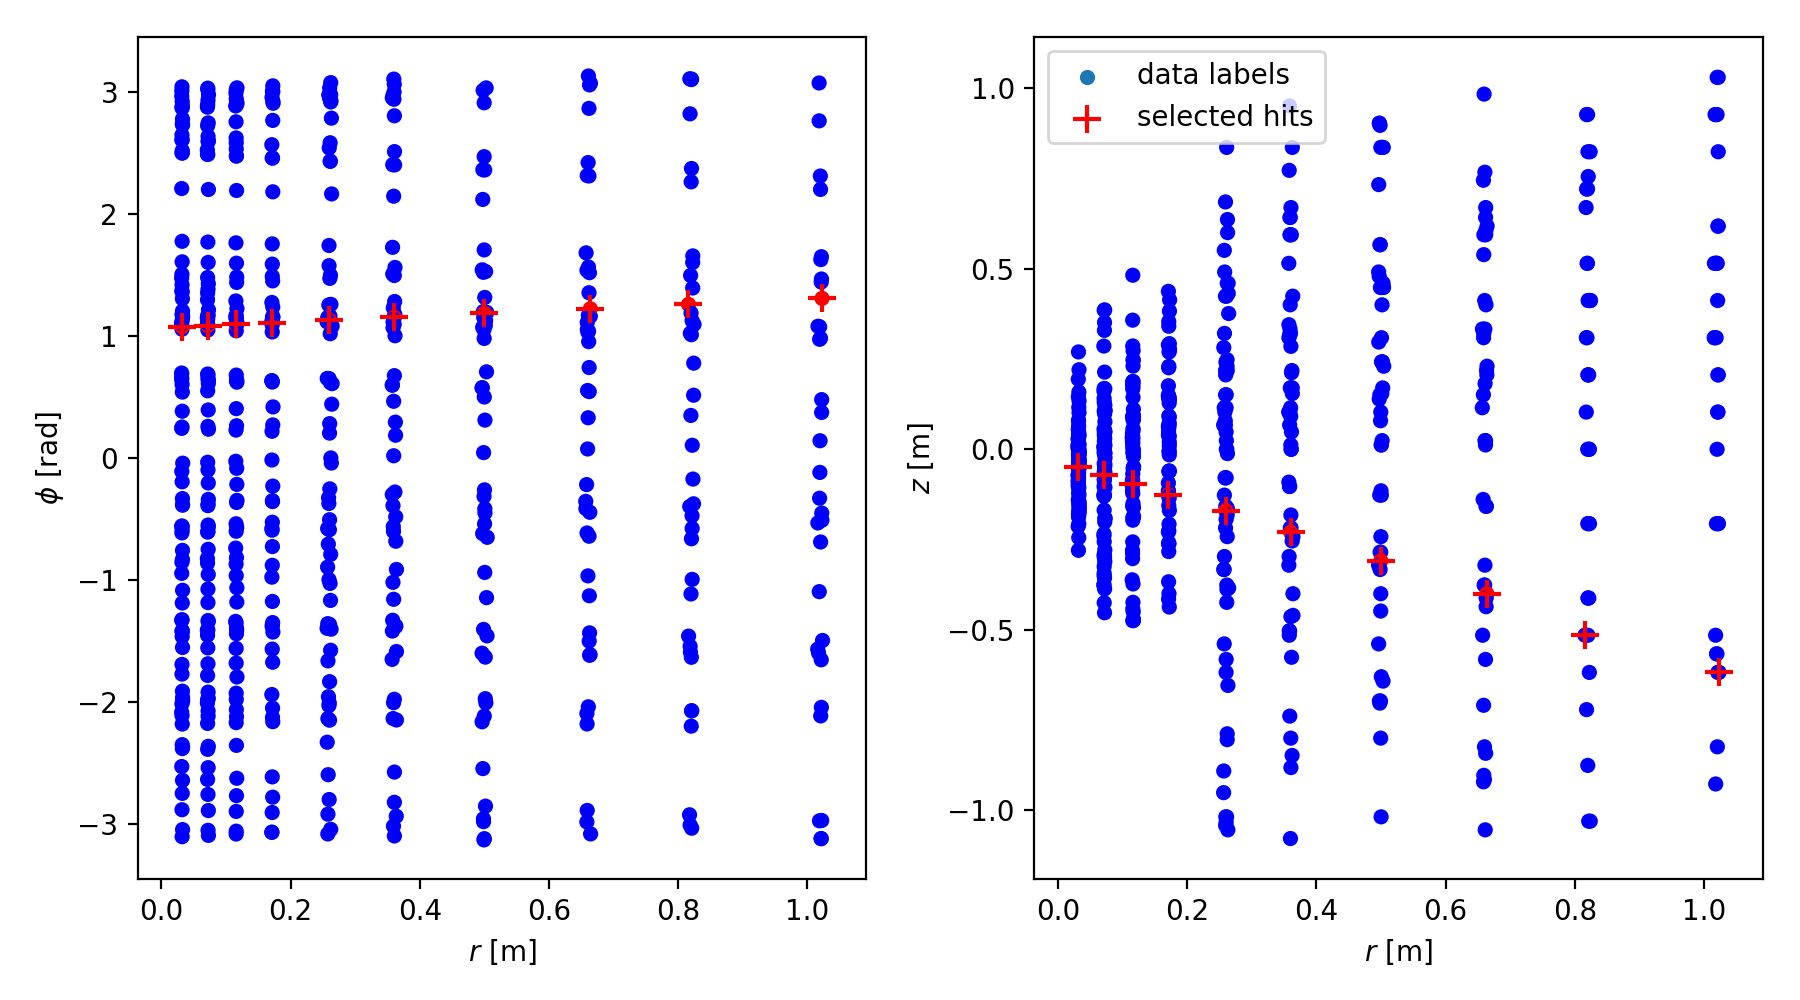

<IPython.core.display.Javascript object>


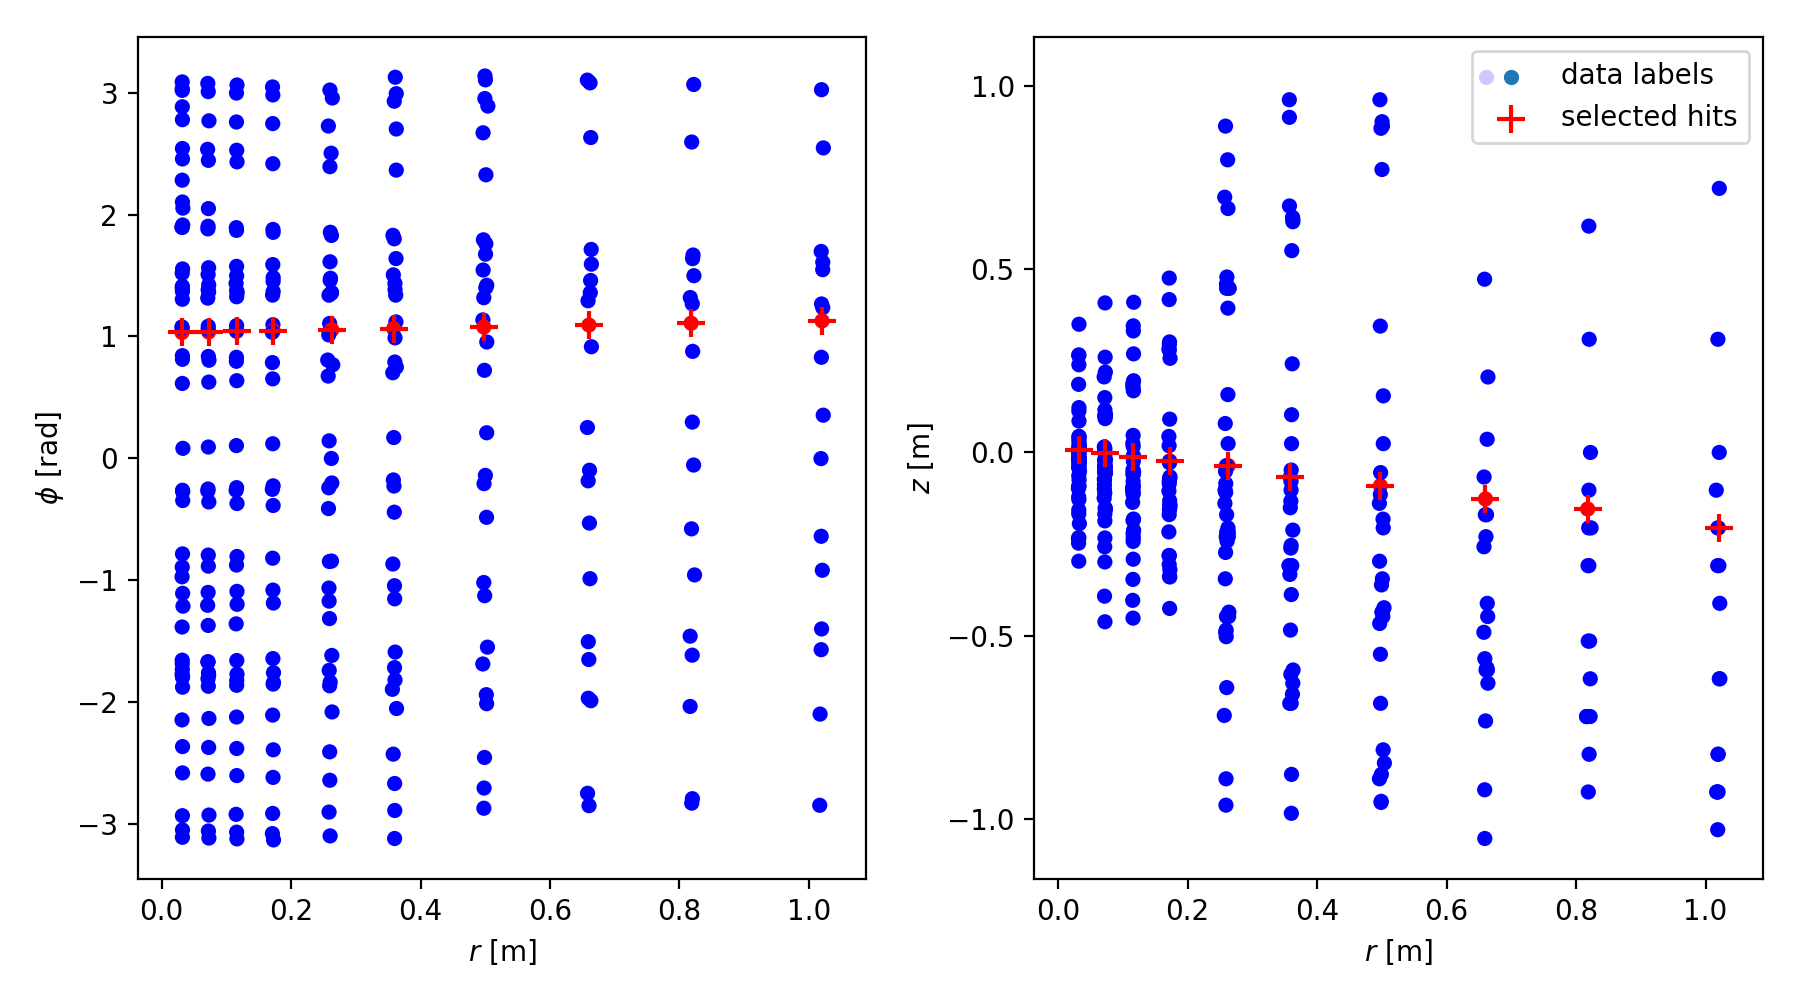

<IPython.core.display.Javascript object>


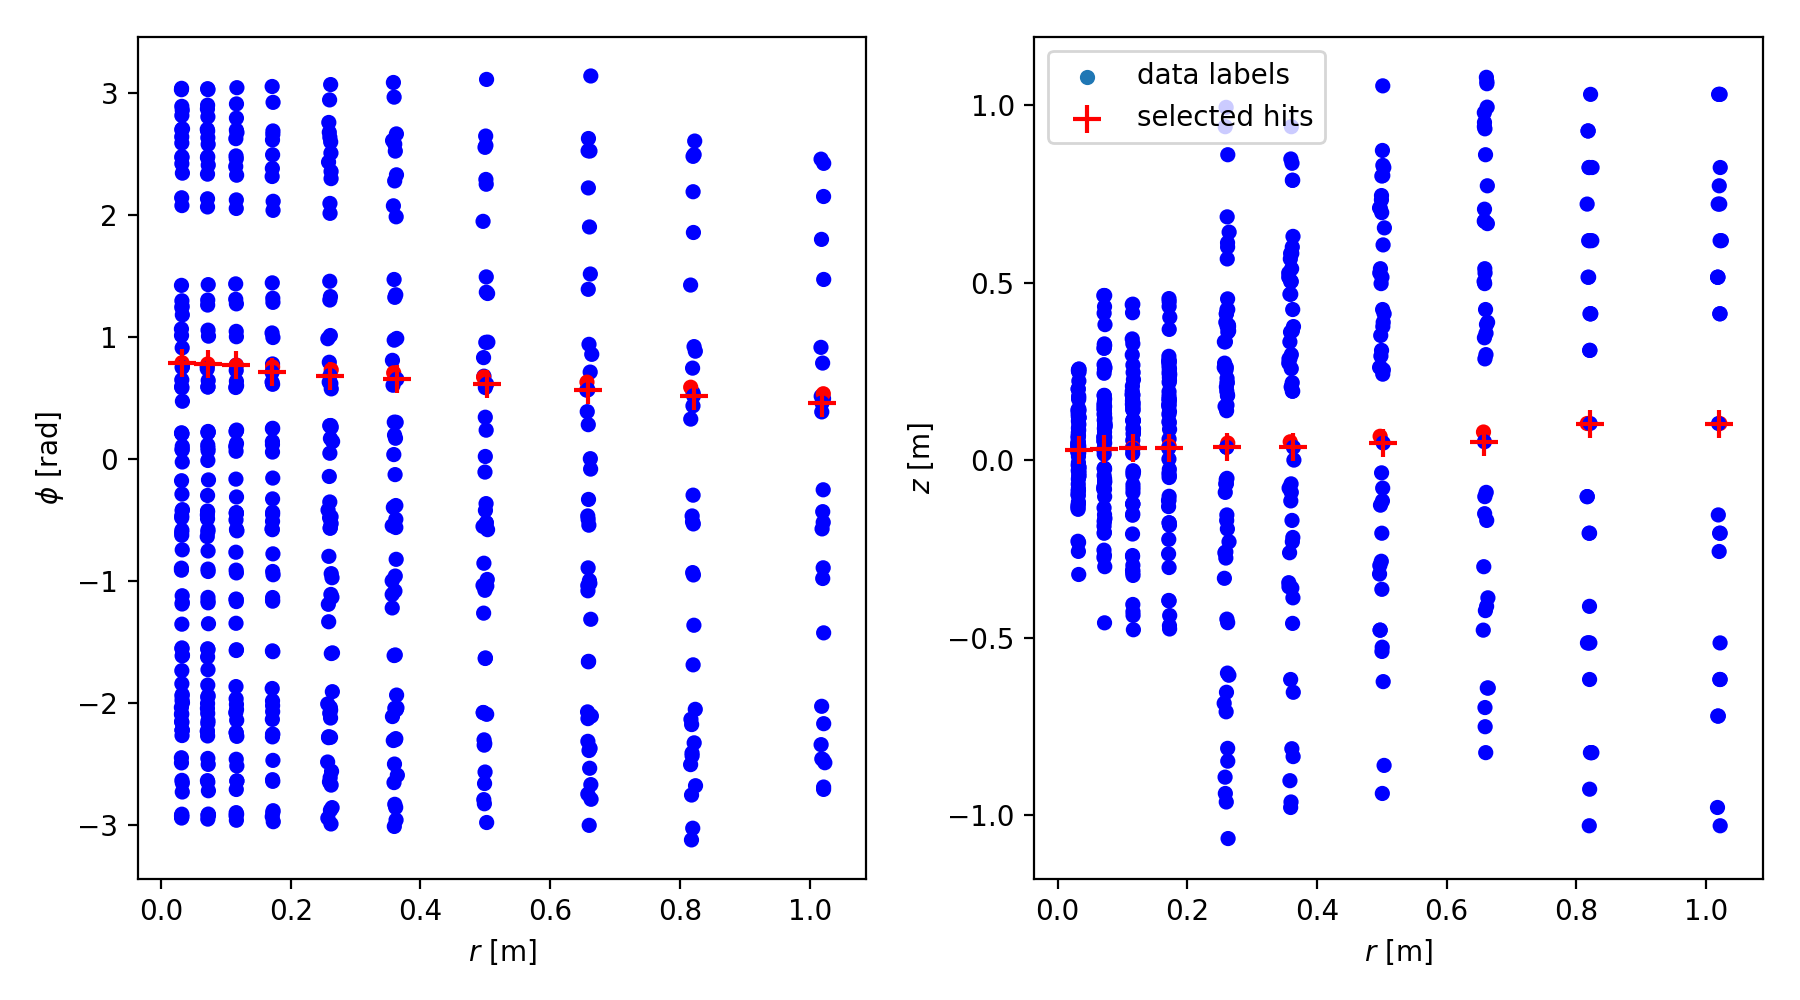

In [18]:
# Loop over samples to draw
for isample in draw_samples:
    sample_key = sample_keys[isample]

    # Get the hits for this sample
    sample_hits = event_groups.get_group(sample_key[0])
    sample_labels = sample_hits.barcode == sample_key[1]

    # Get the hits selected by our model
    sample_sel_idx = pd.Int64Index(sel_indices[isample])
    sample_sel_hits = sample_hits.loc[sample_sel_idx]

    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.scatter(sample_hits.r*0.001, sample_hits.phi, c=sample_labels, s=20, cmap='bwr', label='data labels')
    plt.scatter(sample_sel_hits.r*0.001, sample_sel_hits.phi, marker='+', c='r', s=100, label='selected hits')
    plt.xlabel('$r$ [m]')
    plt.ylabel('$\phi$ [rad]')

    plt.subplot(122)
    plt.scatter(sample_hits.r*0.001, sample_hits.z*0.001, c=sample_labels, s=20, cmap='bwr', label='data labels')
    plt.scatter(sample_sel_hits.r*0.001, sample_sel_hits.z*0.001, marker='+', c='r', s=100, label='selected hits')
    plt.xlabel('$r$ [m]')
    plt.ylabel('$z$ [m]')
    plt.legend(loc=0)

    plt.tight_layout()